In [1]:
from multinterp.unstructured._gpytorch import GaussianProcessRegression
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 1000)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(
    0.04
)

In [3]:
interp = GaussianProcessRegression(train_y, train_x)

/home/alujan/mambaforge-pypy3/envs/multinterp-dev/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Iter 1/50 - Loss: 0.857   lengthscale: 0.693   noise: 0.693
Iter 11/50 - Loss: 0.412   lengthscale: 0.335   noise: 0.311
Iter 21/50 - Loss: 0.048   lengthscale: 0.233   noise: 0.124
Iter 31/50 - Loss: -0.171   lengthscale: 0.222   noise: 0.051
Iter 41/50 - Loss: -0.175   lengthscale: 0.246   noise: 0.030


In [4]:
interp._model.eval()
interp._likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).cuda()
    observed_pred = interp._likelihood(interp._model(test_x))

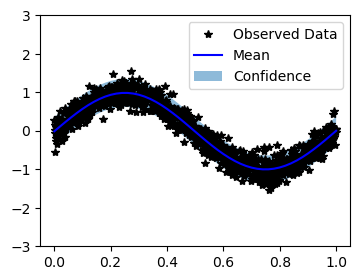

In [5]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), "k*")
    # Plot predictive means as blue line
    ax.plot(test_x.cpu(), observed_pred.mean.cpu(), "b")
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu(), lower.cpu(), upper.cpu(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(["Observed Data", "Mean", "Confidence"])